## Mean Reversion Trading Strategy 

In [17]:
# Description: Mean Reversion Trading Strategy 

In [18]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use('fivethirtyeight')

In [19]:
# Load the data for iShares Silver Trust (SLV)
df = yf.download(tickers=["SLV"], start="2016-05-13", end="2021-12-14")
# Show the data
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-05-13,16.160000,16.290001,16.080000,16.280001,16.280001,6156500
2016-05-16,16.480000,16.549999,16.270000,16.320000,16.320000,6588700
2016-05-17,16.309999,16.500000,16.290001,16.410000,16.410000,5992300
2016-05-18,16.160000,16.320000,15.900000,16.000000,16.000000,13533300
2016-05-19,15.570000,15.720000,15.530000,15.670000,15.670000,17547100
...,...,...,...,...,...,...
2021-12-07,20.680000,20.910000,20.670000,20.809999,20.809999,18763300
2021-12-08,20.700001,20.799999,20.629999,20.760000,20.760000,14075400
2021-12-09,20.459999,20.490000,20.270000,20.299999,20.299999,23767500


In [20]:
# Create a function to calculate the Simple Moving Average (SMA)
def SMA(data, period=30, column='Close'):
    return data[column].rolling(window=period).mean()

In [21]:
# Build and show the dataset
df['SMA'] = SMA(df, 21)
df['Simple_Returns'] = df.pct_change(1)['Close']
df['Log_Returns'] = np.log(1 + df['Simple_Returns'])
df['Ratios'] = df['Close'] / df['SMA']
# Show the data
df

,Open,High,Low,Close,Adj Close,Volume,SMA,Simple_Returns,Log_Returns,Ratios
Date,,,,,,,,,,
2016-05-13,16.160000,16.290001,16.080000,16.280001,16.280001,6156500,NaN,NaN,NaN,NaN
2016-05-16,16.480000,16.549999,16.270000,16.320000,16.320000,6588700,NaN,0.002457,0.002454,NaN
2016-05-17,16.309999,16.500000,16.290001,16.410000,16.410000,5992300,NaN,0.005515,0.005500,NaN
2016-05-18,16.160000,16.320000,15.900000,16.000000,16.000000,13533300,NaN,-0.024985,-0.025302,NaN
2016-05-19,15.570000,15.720000,15.530000,15.670000,15.670000,17547100,NaN,-0.020625,-0.020841,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-12-07,20.680000,20.910000,20.670000,20.809999,20.809999,18763300,22.055714,0.004829,0.004817,0.943520
2021-12-08,20.700001,20.799999,20.629999,20.760000,20.760000,14075400,21.965714,-0.002403,-0.002406,0.945109
2021-12-09,20.459999,20.490000,20.270000,20.299999,20.299999,23767500,21.859524,-0.022158,-0.022407,0.928657


In [22]:
# Get some statistics on the ratio column
df['Ratios'].describe()

count    1387.000000
mean        1.002525
std         0.044221
min         0.723826
25%         0.980286
50%         0.999908
75%         1.024337
max         1.289209
Name: Ratios, dtype: float64

In [23]:
# Get and show the percentile values
percentiles = [15, 20, 50, 80, 85]
# Remove any NA values in the ratios column and store the result in a new variable called ratios
ratios = df['Ratios'].dropna()
# Get the values of the percentiles 
percentile_values = np.percentile(ratios, percentiles)
# Show the values of the percentiles
percentile_values

array([0.96735343, 0.97477517, 0.99990799, 1.02959645, 1.0366027 ])

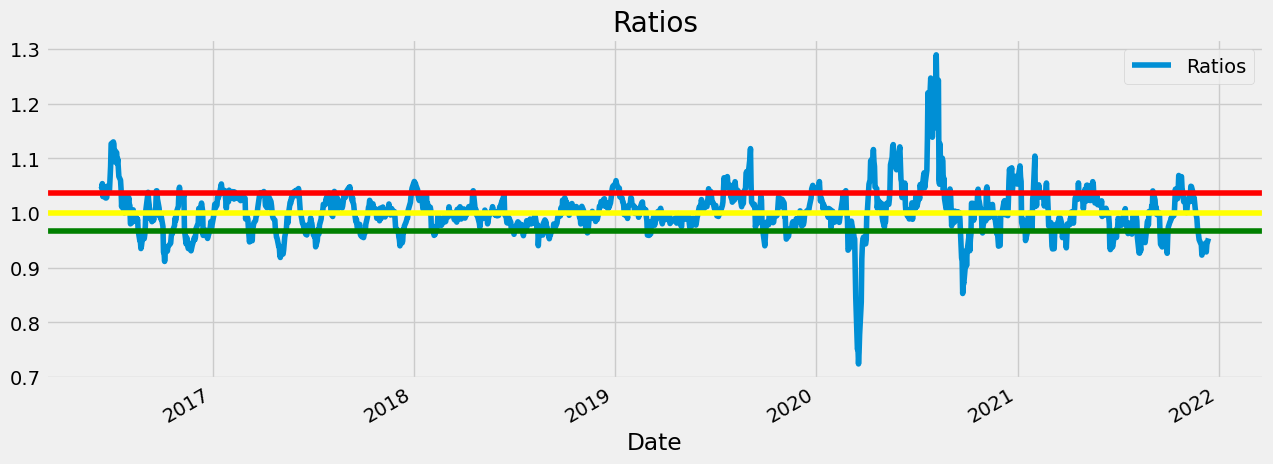

In [24]:
# Plot the ratios 
plt.figure(figsize=(14, 5))
plt.title('Ratios')
df['Ratios'].dropna().plot(legend=True)
plt.axhline(percentile_values[0], c='green', label='15th Percentile')
plt.axhline(percentile_values[2], c='yellow', label='50th Percentile')
plt.axhline(percentile_values[-1], c='red', label='85th Percentile')
plt.show()

In [25]:
# Create buy and sell signals for the strategy
sell = percentile_values[-1] # The 85th percentile threshold where we want to sell
buy = percentile_values[0] # The 15th percentile threshold where we want to buy
# Put -1 where the ratio is greater than the percentile to sell and nan otherwise
df['Positions'] = np.where(df.Ratios > sell, -1, np.nan)
# Put 1 where the ratio is less than percentile to buy and put the current value otherwise
df['Positions'] = np.where(df.Ratios < buy, 1, df['Positions'])
# Use ffill to fill the missing values in the dataframe. ffill stands for forward fill
df['Positions'] = df['Positions'].ffill()

# Get the buy and sell signals
df['Buy'] = np.where(df.Positions == 1, df['Close'], np.nan)
df['Sell'] = np.where(df.Positions == -1, df['Close'], np.nan)

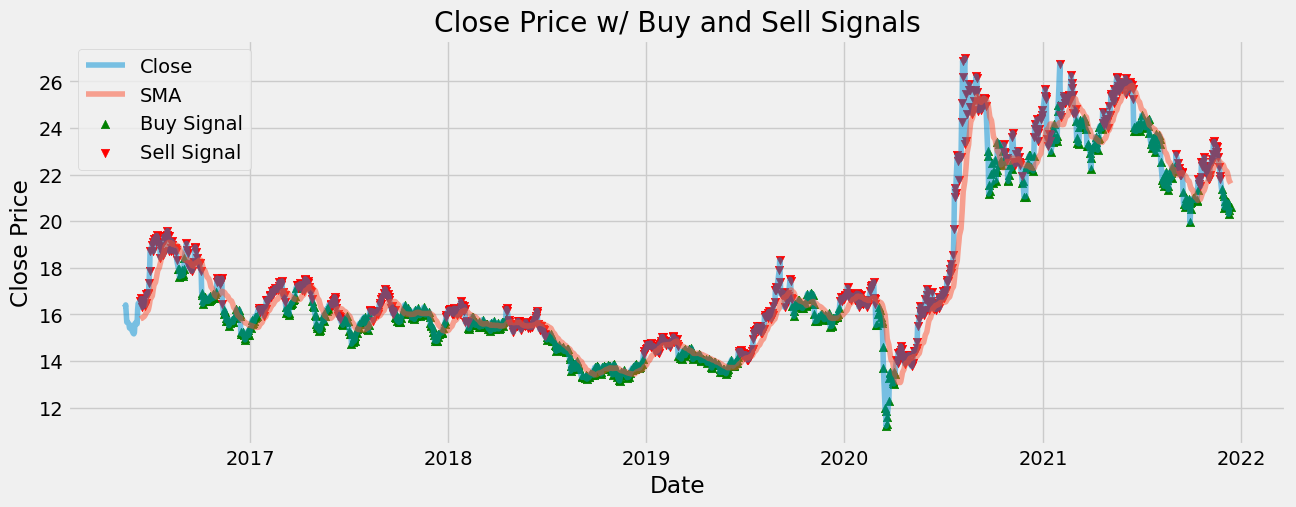

In [26]:
# Visualize the buy and sell signals along with the Close Price
plt.figure(figsize=(14, 5))
plt.title('Close Price w/ Buy and Sell Signals')
plt.plot(df['Close'], alpha=0.5, label='Close')
plt.plot(df['SMA'], alpha=0.5, label="SMA")
plt.scatter(df.index, df["Buy"], color="green", label="Buy Signal", marker="^", alpha=1)
plt.scatter(df.index, df["Sell"], color="red", label="Sell Signal", marker="v", alpha=1)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [27]:
# Calculate the returns for the Mean Reversion Strategy
df['Strategy_Returns'] = df.Positions.shift(1) * df.Log_Returns
df['Strategy_Returns']

Date
2016-05-13         NaN
2016-05-16         NaN
2016-05-17         NaN
2016-05-18         NaN
2016-05-19         NaN
                ...   
2021-12-07    0.004817
2021-12-08   -0.002406
2021-12-09   -0.022407
2021-12-10    0.009804
2021-12-13    0.005352
Name: Strategy_Returns, Length: 1407, dtype: float64

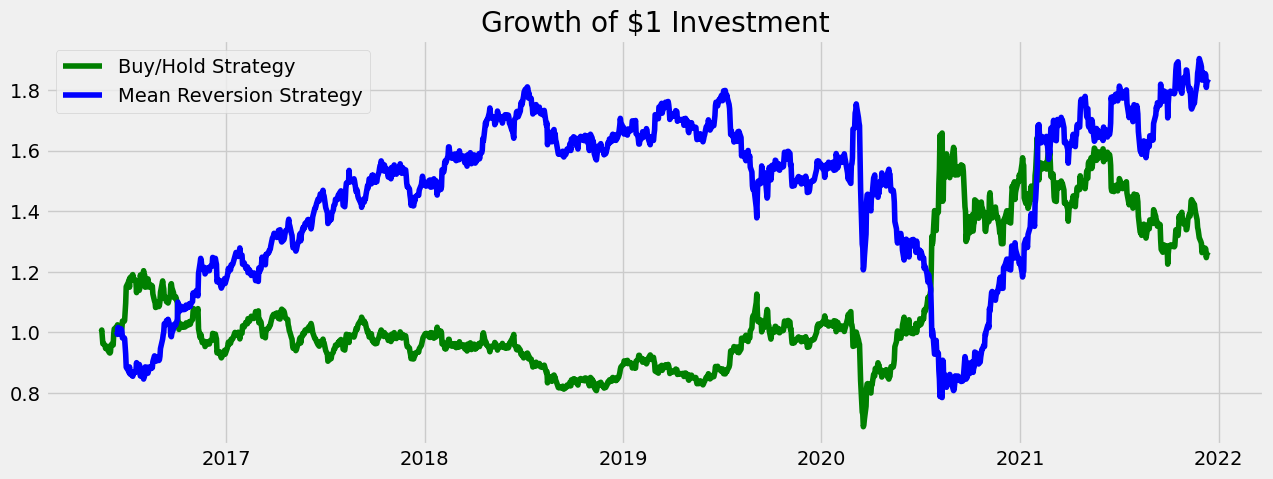

In [28]:
# Plot the cumulative log returns and the Cumulative Mean Reversion Strategy
plt.figure(figsize=(14,5))
plt.title("Growth of $1 Investment")
plt.plot(np.exp(df['Log_Returns'].dropna()).cumprod(), c="green", label='Buy/Hold Strategy')
plt.plot(np.exp(df['Strategy_Returns'].dropna()).cumprod(), c="blue", label='Mean Reversion Strategy')
plt.legend()
plt.show()

In [30]:
# Print the returns for both strategies
print("Buy and Hold Strategy Returns: ", np.exp(df['Log_Returns'].dropna()).cumprod()[-1] - 1)
print("Mean Reversion Strategy Returns: ", np.exp(df['Strategy_Returns'].dropna()).cumprod()[-1] - 1)

Buy and Hold Strategy Returns:  0.26597050006625644
Mean Reversion Strategy Returns:  0.8366893651378411


/tmp/ipykernel_544/1159182739.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Buy and Hold Strategy Returns: ", np.exp(df['Log_Returns'].dropna()).cumprod()[-1] - 1)
/tmp/ipykernel_544/1159182739.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Mean Reversion Strategy Returns: ", np.exp(df['Strategy_Returns'].dropna()).cumprod()[-1] - 1)
